## 1-Import Libraries

In [21]:
!pip install -q segmentation-models-pytorch torch torchvision albumentations --extra-index-url https://download.pytorch.org/whl/cu118

In [22]:
import os
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torchvision.utils import make_grid
import torchvision.transforms as transforms
import albumentations as A
from albumentations.pytorch import ToTensorV2
import segmentation_models_pytorch as smp
from segmentation_models_pytorch import utils
from osgeo import gdal
from torch.utils.data import Dataset, DataLoader
import csv
from tqdm import tqdm
import pandas as pd
import time
import matplotlib.pyplot as plt
import random
import cv2

In [23]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')

else:
  print(gpu_info)

Sat Mar  8 12:59:58 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   55C    P0             28W /   70W |    5282MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

## 2-Define Training/Validation/Testing path

In [24]:
import os
from google.colab import drive
import zipfile

# Mount Google Drive
drive.mount('/content/drive')

# Define path to your ZIP file in Google Drive
zip_path = '/content/drive/MyDrive/School/Courses/thesis/D2.zip'

# Extract the ZIP file
extract_path = '/content/dataset'
if not os.path.exists(extract_path):
    os.makedirs(extract_path)
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [25]:
# Set dataset directory in Colab
DATA_DIR = os.path.join(extract_path , "D2")

x_train_dir = os.path.join(DATA_DIR, 'train')
y_train_dir = os.path.join(DATA_DIR, 'train_labels')

x_valid_dir = os.path.join(DATA_DIR, 'val')
y_valid_dir = os.path.join(DATA_DIR, 'val_labels')

x_test_dir = os.path.join(DATA_DIR, 'test')
y_test_dir = os.path.join(DATA_DIR, 'test_labels')

print("Dataset extracted and directories set.")

Dataset extracted and directories set.


In [26]:
labels_path = os.path.join(extract_path, 'labels_class01234.csv')

class_dict = pd.read_csv(labels_path)

# Get class names
class_names = class_dict['class'].tolist()

# Get class RGB values
class_rgb_values = class_dict[['R','G','B']].values.tolist()
#print(class_rgb_values)

print('All dataset classes and their corresponding RGB values in labels:')
print('Class Names: ', class_names)
print('Class RGB values: ', class_rgb_values)


All dataset classes and their corresponding RGB values in labels:
Class Names:  ['Unlabeled', 'Others', 'Low-severity', 'High-severity', 'Healthy']
Class RGB values:  [[0, 0, 0], [204, 204, 204], [255, 255, 0], [255, 0, 0], [85, 255, 0]]


In [27]:
# Convert class_names to lowercase for matching
class_names_lower = [name.lower() for name in class_names]

select_classes = ['Unlabeled', 'Others', 'Low-severity', 'High-severity', 'Healthy']
print("Number of selected classes:", len(select_classes))

# Get RGB values of required classes without altering the case of select_classes
select_class_indices = [class_names_lower.index(cls.lower()) for cls in select_classes]
select_class_rgb_values = np.array(class_rgb_values)[select_class_indices]
#print(select_class_rgb_values)

print('Selected classes and their corresponding RGB values in labels:')
print('Class Names: ', [class_names[i] for i in select_class_indices])  # Original case class names
print('Class RGB values: ', select_class_rgb_values.tolist())

Number of selected classes: 5
Selected classes and their corresponding RGB values in labels:
Class Names:  ['Unlabeled', 'Others', 'Low-severity', 'High-severity', 'Healthy']
Class RGB values:  [[0, 0, 0], [204, 204, 204], [255, 255, 0], [255, 0, 0], [85, 255, 0]]


## 3-Function to pre-process data for DL model

### 3-1 Helper functions for viz. & one-hot encoding/decoding

In [28]:
# helper function for data visualization
def visualize(**images):
    """Visualize data with multiple images, where images with more than 3 bands will have only the first three visualized (B1=Blue, B2=Green, B3=Red)."""
    n_images = len(images)
    plt.figure(figsize=(10, 4))
    for idx, (name, image) in enumerate(images.items()):
        plt.subplot(1, n_images, idx + 1)
        plt.xticks([]); plt.yticks([])

        # Convert PyTorch tensor to NumPy array if necessary
        if torch.is_tensor(image):
            image = image.cpu().numpy()

        # Correctly handle images with 5/6 bands by extracting the first three (B1, B2, B3) for RGB visualization
        if image.shape[-1] == 6:
            # Extract B1 (Blue), B2 (Green), B3 (Red)
            RGB_image = image[..., [2, 1, 0]]  # Reorder to RGB
            plt.imshow(RGB_image)
        else:
            plt.imshow(image)

        plt.title(name.replace('_', ' ').title(), fontsize=10)
    plt.show()

# Perform one hot encoding on label
def one_hot_encode(label, label_values):
    """
    Convert a segmentation image label array to one-hot format
    by replacing each pixel value with a vector of length num_classes
    # Arguments
        label: The 2D array segmentation image label
        label_values

    # Returns
        A 2D array with the same width and hieght as the input, but
        with a depth size of num_classes
    """
    semantic_map = []
    for colour in label_values:
        equality = np.equal(label, colour)
        class_map = np.all(equality, axis = -1)
        semantic_map.append(class_map)
    semantic_map = np.stack(semantic_map, axis=-1).astype(np.uint8)

    return semantic_map

# Perform reverse one-hot-encoding on labels / preds
def reverse_one_hot(image):
    """
    Transform a 2D array in one-hot format (depth is num_classes),
    to a 2D array with only 1 channel, where each pixel value is
    the classified class key.
    # Arguments
        image: The one-hot format image

    # Returns
        A 2D array with the same width and hieght as the input, but
        with a depth size of 1, where each pixel value is the classified
        class key.
    """
    x = np.argmax(image, axis = -1)
    return x

# Perform colour coding on the reverse-one-hot outputs
def colour_code_segmentation(image, label_values):
    """
    Given a 1-channel array of class keys, colour code the segmentation results.
    # Arguments
        image: single channel array where each value represents the class key, can be a NumPy array or a PyTorch tensor.
        label_values

    # Returns
        Colour coded image for segmentation visualization
    """
    if torch.is_tensor(image):
        image = image.cpu().numpy()

    colour_codes = np.array(label_values)
    x = colour_codes[image.astype(int)]

    return x

### 3-2 Config RiceDiseaseDataset

In [29]:
class RiceDiseaseDataset(Dataset):
    def __init__(self, images_dir, masks_dir, class_rgb_values=None, transform=None, augmentation=None, preprocessing=None):
        self.image_paths = [os.path.join(images_dir, image_id) for image_id in sorted(os.listdir(images_dir))]
        self.mask_paths = [os.path.join(masks_dir, image_id) for image_id in sorted(os.listdir(masks_dir))]
        self.class_rgb_values = class_rgb_values
        self.transform = transform  # Custom transformations if any
        self.augmentation = augmentation  # Augmentation pipeline
        self.preprocessing = preprocessing  # Preprocessing pipeline (e.g., normalization)

    def __getitem__(self, i):
        # Read images and masks
        img_dataset = gdal.Open(self.image_paths[i])
        image = img_dataset.ReadAsArray()
        image = np.moveaxis(image, 0, -1)  # Channels last

        mask_dataset = gdal.Open(self.mask_paths[i])
        mask = mask_dataset.ReadAsArray()
        mask_rgb = colour_code_segmentation(mask, self.class_rgb_values)
        mask_one_hot = one_hot_encode(mask_rgb, self.class_rgb_values)

        # Apply augmentations
        if self.augmentation:
            augmented = self.augmentation(image=image, mask=mask_one_hot)
            image, mask_one_hot = augmented['image'], augmented['mask']

        # Apply preprocessing
        if self.preprocessing:
            preprocessed = self.preprocessing(image=image, mask=mask_one_hot)
            image, mask_one_hot = preprocessed['image'], preprocessed['mask']

        return image, mask_one_hot

    def __len__(self):
        return len(self.image_paths)

    def get_image_path(self, index):
        # Directly return the path from the saved image_paths attribute
        return self.image_paths[index]

### 3-3 Visualize Sample Image and Mask

Image dimension (256, 256, 6)
Mask dimension (256, 256, 5)


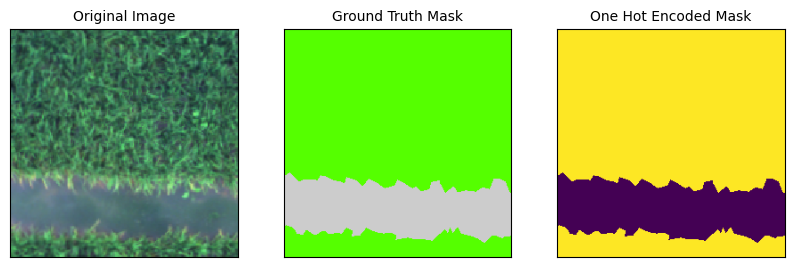

In [30]:
dataset = RiceDiseaseDataset(x_train_dir, y_train_dir, class_rgb_values=select_class_rgb_values)
random_idx = random.randint(0, len(dataset)-1)
image, mask = dataset[20]
print("Image dimension",image.shape)
print("Mask dimension",mask.shape)

visualize(
    original_image = image,
    ground_truth_mask = colour_code_segmentation(reverse_one_hot(mask), select_class_rgb_values),
    one_hot_encoded_mask = reverse_one_hot(mask)
)

### 3-4 Define pre-processing function

In [31]:
# Define data augmentation
def get_training_augmentation():
    train_transform = [
        # RandomCrop is always applied with the specified height and width
        A.RandomCrop(height=256, width=256, always_apply=True),
        # One of the following is applied with 75% probability
        A.OneOf([
            A.HorizontalFlip(p=1),
            A.VerticalFlip(p=1),
            A.RandomRotate90(p=1),
        ], p=0.75),
    ]
    return A.Compose(train_transform)

def to_tensor(x, **kwargs):
    """
    Convert images and masks to PyTorch tensors.
    """
    if x.ndim == 3:  # For 3D arrays (e.g., HxWxC)
        return x.transpose(2, 0, 1).astype('float32')
    elif x.ndim == 2:  # For 2D arrays (e.g., HxW), like masks
        return np.expand_dims(x, 0).astype('float32')  # Adds a channel dimension
    else:
        return x

def get_preprocessing(preprocessing_fn=None):
    """
    Construct a preprocessing transform pipeline.

    Args:
        preprocessing_fn (callable, optional): Additional preprocessing function
            (not used if your data is already normalized).

    Returns:
        A.Compose: An albumentations.Compose object with preprocessing transforms.
    """
    _transform = [A.Lambda(image=to_tensor, mask=to_tensor)]
    return A.Compose(_transform)

###  3-5 Apply and visualize pre-processing function

<ipython-input-31-f0eda9a1cf33>:5: UserWarning: Argument(s) 'always_apply' are not valid for transform RandomCrop
  A.RandomCrop(height=256, width=256, always_apply=True),


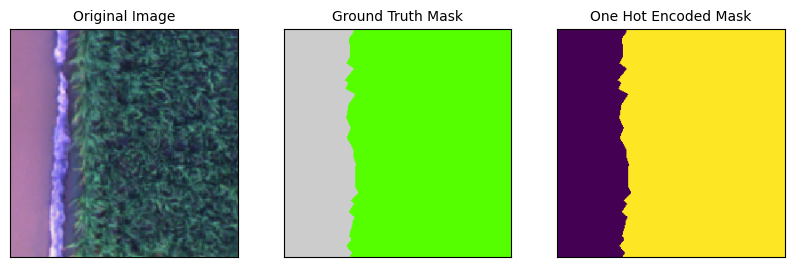

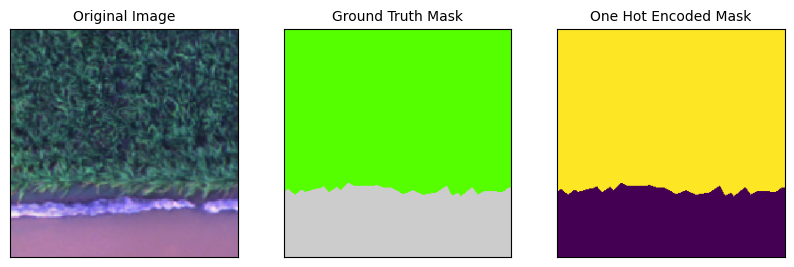

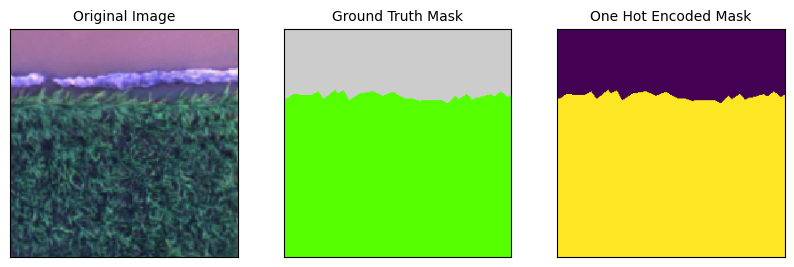

In [32]:
augmented_dataset = RiceDiseaseDataset(
    x_train_dir, y_train_dir,
    augmentation=get_training_augmentation(),
    class_rgb_values=select_class_rgb_values,
)

random_idx = random.randint(0, len(augmented_dataset)-1)

# Different augmentations on a random image/mask pair (256*256 crop)
for i in range(3):
    image, mask = augmented_dataset[random_idx]
    visualize(
        original_image = image,
        ground_truth_mask = colour_code_segmentation(reverse_one_hot(mask), select_class_rgb_values),
        one_hot_encoded_mask = reverse_one_hot(mask)
    )

## 4-Model Training (U-Net with ResNet101)

![u-net_training_image_segmentation_models_in_pytorch_header.png](attachment:u-net_training_image_segmentation_models_in_pytorch_header.png)

### 4-1 Model Definition

In [33]:
ENCODER = 'resnet101'
ENCODER_WEIGHTS = 'imagenet'
CLASSES = select_classes
ACTIVATION = 'sigmoid'

#select model
model = smp.Unet(
    encoder_name=ENCODER,
    encoder_weights=ENCODER_WEIGHTS,
    classes=len(CLASSES),
    activation=ACTIVATION,
)

# Modify the first convolutional layer to accept 5/6 channels
# Note: Direct assignment assumes the structure of the model and may need adjustment
if hasattr(model.encoder, 'conv1'):
    model.encoder.conv1 = torch.nn.Conv2d(6, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
else:
    print("The model's encoder does not have a 'conv1' attribute. Please check the encoder structure.")


preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

### 4-2 Set-up the dataset for Training / Validation / Testing

In [34]:
train_dataset = RiceDiseaseDataset(
    images_dir=x_train_dir,
    masks_dir=y_train_dir,
    class_rgb_values=select_class_rgb_values,
    augmentation=get_training_augmentation(),
    preprocessing=get_preprocessing(preprocessing_fn)
)

valid_dataset = RiceDiseaseDataset(
    images_dir=x_valid_dir,
    masks_dir=y_valid_dir,
    class_rgb_values=select_class_rgb_values,
    augmentation=None,  # No augmentation for validation data
    preprocessing=get_preprocessing(preprocessing_fn)
)

# Instantiate DataLoaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=0)
valid_loader = DataLoader(valid_dataset, batch_size=16, shuffle=False, num_workers=0)

<ipython-input-31-f0eda9a1cf33>:5: UserWarning: Argument(s) 'always_apply' are not valid for transform RandomCrop
  A.RandomCrop(height=256, width=256, always_apply=True),


### 4-3 Re-check the dimension before feeding to the model

In [35]:
def print_random_batch_info(loader, name):
    # Randomly select a batch
    for images, masks in loader:
        # Print shapes
        print(f"{name} images shape: {images.shape}")
        print(f"{name} masks shape: {masks.shape}")

        # Print data types
        print(f"{name} images data type: {images.dtype}")
        print(f"{name} masks data type: {masks.dtype}")

        # Optionally, print the type of the container (should be torch.Tensor)
        print(f"{name} images type: {type(images)}")
        print(f"{name} masks type: {type(masks)}")

        # If you're interested in the first element's type inside the batch (assuming it's not empty)
        if len(images) > 0 and len(masks) > 0:
            print(f"{name} first image element type: {type(images[0])}")
            print(f"{name} first mask element type: {type(masks[0])}")

        break  # Break after the first batch to only print one random batch's info

# Execute the function for train, valid, and test DataLoader objects
print_random_batch_info(train_loader, "Train")
print_random_batch_info(valid_loader, "Valid")

Train images shape: torch.Size([16, 6, 256, 256])
Train masks shape: torch.Size([16, 5, 256, 256])
Train images data type: torch.float32
Train masks data type: torch.float32
Train images type: <class 'torch.Tensor'>
Train masks type: <class 'torch.Tensor'>
Train first image element type: <class 'torch.Tensor'>
Train first mask element type: <class 'torch.Tensor'>
Valid images shape: torch.Size([16, 6, 256, 256])
Valid masks shape: torch.Size([16, 5, 256, 256])
Valid images data type: torch.float32
Valid masks data type: torch.float32
Valid images type: <class 'torch.Tensor'>
Valid masks type: <class 'torch.Tensor'>
Valid first image element type: <class 'torch.Tensor'>
Valid first mask element type: <class 'torch.Tensor'>


### 4-4 Set Hyperparameters

In [36]:
# Set flag to train the model or not. If set to 'False', only prediction is performed (using an older model checkpoint)
TRAINING = True

# Set num of epochs
EPOCHS = 100

# Set device: `cuda` or `cpu`
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define loss function
loss_fn = smp.utils.losses.CrossEntropyLoss()

# Define metrics
metrics = [
    smp.utils.metrics.IoU(threshold=0.5),
    smp.utils.metrics.Fscore(threshold=0.5),
    smp.utils.metrics.Accuracy(threshold=0.5),
    smp.utils.metrics.Recall(threshold=0.5),
    smp.utils.metrics.Precision(threshold=0.5)
]

# Define optimizer
optimizer = torch.optim.Adam([
    dict(params=model.parameters(), lr=0.001),  # Adjust learning rate as necessary
])

# Define learning rate scheduler (not used in this NB)
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
    optimizer, T_0=1, T_mult=2, eta_min=5e-5,  # Adjust these parameters as necessary
)

### 4-4 Apply model configuration

In [37]:
train_epoch = smp.utils.train.TrainEpoch(
    model,
    loss=loss_fn,
    metrics=metrics,
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model,
    loss=loss_fn,
    metrics=metrics,
    device=DEVICE,
    verbose=True,
)

###  4-5 Set-up parth to save the results

In [38]:
# Directory to save logs and models
logs_dir = r'/content/drive/MyDrive/School/Courses/thesis/BLB/logs'

os.makedirs(logs_dir, exist_ok=True)

# Specify the model file name
model_file_name = 'best_model.pth'

# Construct the full path where the model will be saved
model_save_path = os.path.join(logs_dir, model_file_name)

logs_csv_path = os.path.join(logs_dir, 'logs.csv')

### 4-6 Run the model

In [39]:
# Start timing
start_time = time.time()

if TRAINING:
    best_iou_score = 0.0

    for i in range(EPOCHS):
        print('\nEpoch: {}'.format(i))
        train_logs = train_epoch.run(train_loader)
        valid_logs = valid_epoch.run(valid_loader)

        # Initialize the CSV file and write the headers if it's the first epoch
        if i == 0:
            with open(logs_csv_path, 'w', newline='') as csvfile:
                log_writer = csv.writer(csvfile)
                headers = ['epoch'] + list(train_logs.keys()) + ['val_' + key for key in valid_logs.keys()]
                log_writer.writerow(headers)

        # Append logs to CSV for the current epoch
        with open(logs_csv_path, 'a', newline='') as csvfile:
            log_writer = csv.writer(csvfile)
            row = [i] + list(train_logs.values()) + list(valid_logs.values())
            log_writer.writerow(row)

        # Save model if a better val IoU score is obtained
        if best_iou_score < valid_logs['iou_score']:
            best_iou_score = valid_logs['iou_score']
            torch.save(model, model_save_path)
            print('Model saved!')


# End timing and print total training time
end_time = time.time()
print("Training completed in {:.2f} hours.".format((end_time - start_time) / 3600))


Epoch: 0
valid: 100%|██████████| 18/18 [00:06<00:00,  2.83it/s, cross_entropy_loss - 1.059, iou_score - 0.7873, fscore - 0.8603, accuracy - 0.9429, recall - 0.8666, precision - 0.8541]
Model saved!

Epoch: 1
valid: 100%|██████████| 18/18 [00:06<00:00,  2.82it/s, cross_entropy_loss - 0.9858, iou_score - 0.8427, fscore - 0.906, accuracy - 0.9552, recall - 0.9663, precision - 0.8613]
Model saved!

Epoch: 2
valid: 100%|██████████| 18/18 [00:06<00:00,  2.65it/s, cross_entropy_loss - 0.9898, iou_score - 0.8578, fscore - 0.9152, accuracy - 0.9653, recall - 0.9255, precision - 0.9052]
Model saved!

Epoch: 3
valid: 100%|██████████| 18/18 [00:06<00:00,  2.75it/s, cross_entropy_loss - 0.9658, iou_score - 0.8842, fscore - 0.9334, accuracy - 0.972, recall - 0.9542, precision - 0.9141]
Model saved!

Epoch: 4
valid: 100%|██████████| 18/18 [00:06<00:00,  2.59it/s, cross_entropy_loss - 0.9917, iou_score - 0.8476, fscore - 0.909, accuracy - 0.9633, recall - 0.9209, precision - 0.8975]

Epoch: 5
valid: 

KeyboardInterrupt: 

### 4-7 Plot model logs

In [40]:
# Load the metrics from the CSV file
metrics_df = pd.read_csv(logs_csv_path)

# Print the column names to verify
print(metrics_df.columns)

Index(['epoch', 'cross_entropy_loss', 'iou_score', 'fscore', 'accuracy',
       'recall', 'precision', 'val_cross_entropy_loss', 'val_iou_score',
       'val_fscore', 'val_accuracy', 'val_recall', 'val_precision'],
      dtype='object')


Saved plot to /content/drive/MyDrive/School/Courses/thesis/BLB/logs/plots/IoU_over_epochs.png


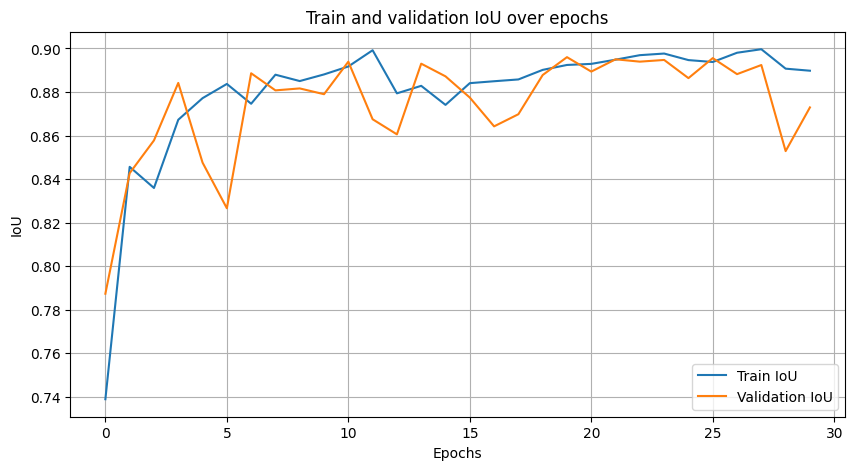

Saved plot to /content/drive/MyDrive/School/Courses/thesis/BLB/logs/plots/Cross_Entropy_Loss_over_epochs.png


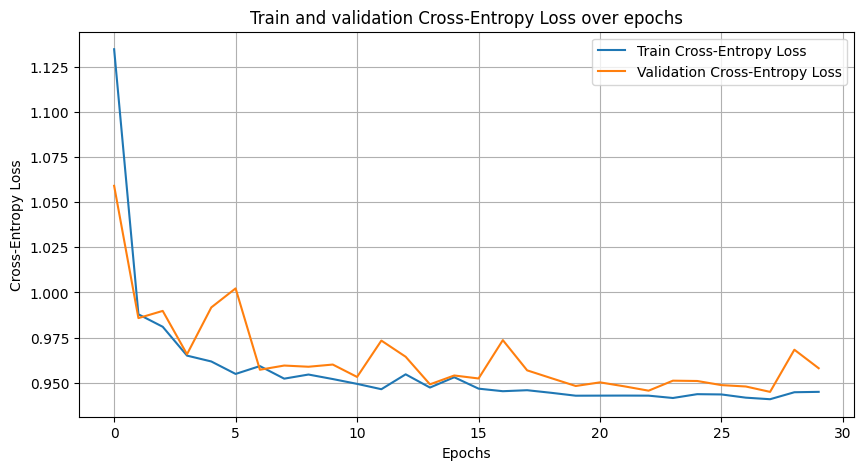

Saved plot to /content/drive/MyDrive/School/Courses/thesis/BLB/logs/plots/F1_Score_over_epochs.png


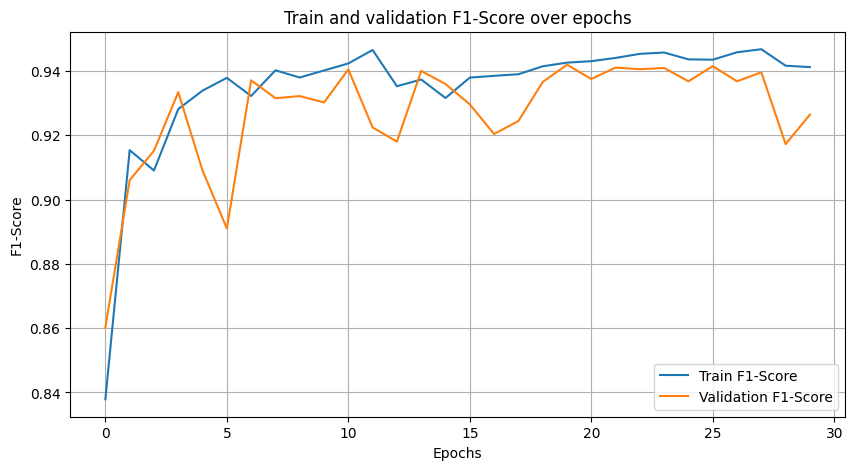

Saved plot to /content/drive/MyDrive/School/Courses/thesis/BLB/logs/plots/Accuracy_over_epochs.png


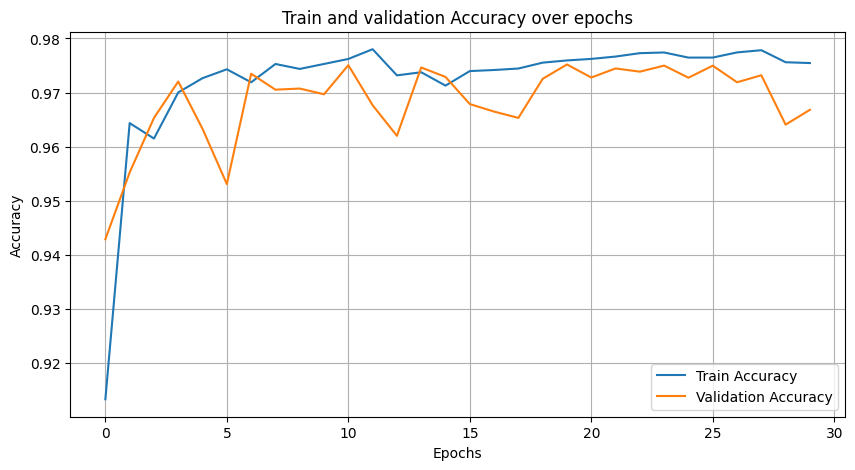

Saved plot to /content/drive/MyDrive/School/Courses/thesis/BLB/logs/plots/Recall_over_epochs.png


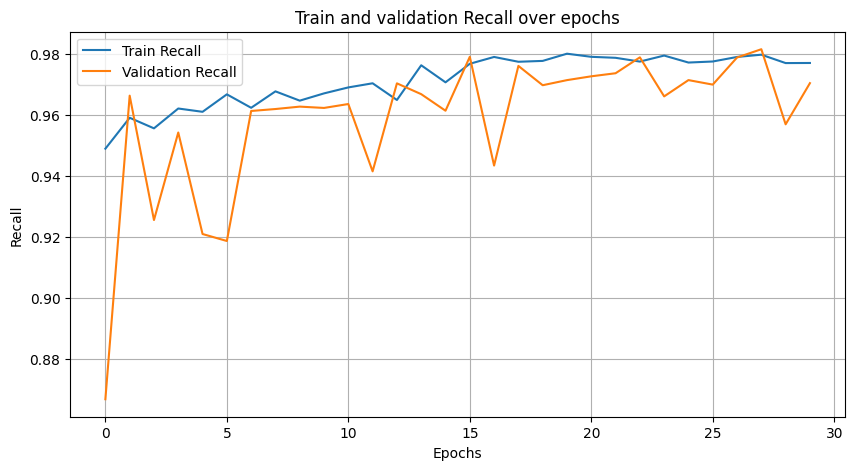

Saved plot to /content/drive/MyDrive/School/Courses/thesis/BLB/logs/plots/Precision_over_epochs.png


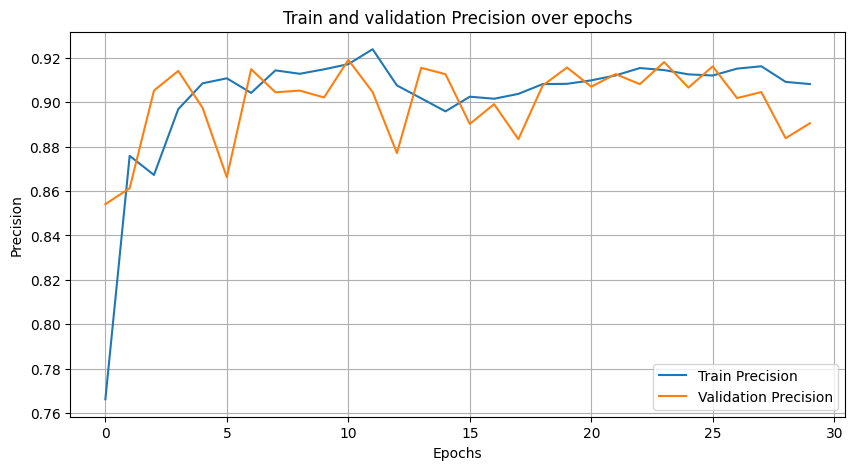

In [41]:
import os
import matplotlib.pyplot as plt

# Specify the directory where you want to save the plots
plots_dir = os.path.join(logs_dir, "plots")
os.makedirs(plots_dir, exist_ok=True)  # Create the directory if it doesn't exist

# Dictionary to map the old column names to the new, more descriptive names
new_column_names = {
    'iou_score': 'IoU',
    'cross_entropy_loss': 'Cross-Entropy Loss',
    'fscore': 'F1-Score',
    'accuracy': 'Accuracy',
    'recall': 'Recall',
    'precision': 'Precision'
}

# Rename the columns in the DataFrame
metrics_df.rename(columns=new_column_names, inplace=True)

# Dictionary for validation metric column names
validation_column_names = {
    'IoU': 'val_iou_score',
    'Cross-Entropy Loss': 'val_cross_entropy_loss',
    'F1-Score': 'val_fscore',
    'Accuracy': 'val_accuracy',
    'Recall': 'val_recall',
    'Precision': 'val_precision'
}

# List of new metric names (including 'Cross-Entropy Loss')
metrics = list(new_column_names.values())

for metric in metrics:
    plt.figure(figsize=(10, 5))

    # Plot training metric
    train_metric = metric
    if train_metric in metrics_df.columns:
        plt.plot(metrics_df['epoch'], metrics_df[train_metric], label=f'Train {metric}')

    # Plot validation metric
    val_metric = validation_column_names.get(metric)
    if val_metric and val_metric in metrics_df.columns:
        plt.plot(metrics_df['epoch'], metrics_df[val_metric], label=f'Validation {metric}')
    else:
        print(f"Warning: Validation column '{val_metric}' not found in DataFrame.")

    plt.title(f'Train and validation {metric} over epochs')
    plt.xlabel('Epochs')
    plt.ylabel(metric)
    plt.legend()
    plt.grid(True)

    # Save the plot to the specified directory
    filename = metric.replace(' ', '_').replace('(', '').replace(')', '').replace('-', '_')
    plot_path = os.path.join(plots_dir, f'{filename}_over_epochs.png')
    plt.savefig(plot_path)
    print(f'Saved plot to {plot_path}')

    # Display the plot
    plt.show()


## 5-Model Evaluation (U-Net with ResNet101)

### 5-1 Define output directories

In [42]:
# Output directories

# (1) Path for predicted mask (.tiff)

# Create the path for the sample_preds_folder
sample_preds_folder = os.path.join(logs_dir, "1_predicted")

# Check if the directory exists (this check is redundant due to exist_ok=True)
if not os.path.exists(sample_preds_folder):
    # Make the directory if it doesn't exist
    os.makedirs(sample_preds_folder, exist_ok=True)
    print(f"The folder '{sample_preds_folder}' was created because it did not exist.")
else:
    print(f"The folder '{sample_preds_folder}' already exists.")

#(2) Path for Orginal image vs Predicted mask

# Create the path for the sample_preds_folder2
sample_preds_folder2 = os.path.join(logs_dir, "2_original_and_predicted")

# Check if the directory exists (this check is redundant due to exist_ok=True)
if not os.path.exists(sample_preds_folder2):
    # Make the directory if it doesn't exist
    os.makedirs(sample_preds_folder2, exist_ok=True)
    print(f"The folder '{sample_preds_folder2}' was created because it did not exist.")
else:
    print(f"The folder '{sample_preds_folder2}' already exists.")

# (3) Path for Original image / Ground truth mask / Predicted mask

# Create the path for the sample_preds_folder3
sample_preds_folder3 = os.path.join(logs_dir, "3_ori_gt_pd")

# Check if the directory exists (this check is redundant due to exist_ok=True)
if not os.path.exists(sample_preds_folder3):
    # Make the directory if it doesn't exist
    os.makedirs(sample_preds_folder3, exist_ok=True)
    print(f"The folder '{sample_preds_folder3}' was created because it did not exist.")
else:
    print(f"The folder '{sample_preds_folder3}' already exists.")

The folder '/content/drive/MyDrive/School/Courses/thesis/BLB/logs/1_predicted' was created because it did not exist.
The folder '/content/drive/MyDrive/School/Courses/thesis/BLB/logs/2_original_and_predicted' was created because it did not exist.
The folder '/content/drive/MyDrive/School/Courses/thesis/BLB/logs/3_ori_gt_pd' was created because it did not exist.


### 5-2 Load dataset and the best model



In [43]:
test_dataset = RiceDiseaseDataset(
    images_dir=x_test_dir,
    masks_dir=y_test_dir,
    class_rgb_values=select_class_rgb_values,
    augmentation=None,  # No augmentation for test data
    preprocessing=get_preprocessing(preprocessing_fn)
)

test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False, num_workers=0)

print_random_batch_info(test_loader, "Test")

Test images shape: torch.Size([8, 6, 256, 256])
Test masks shape: torch.Size([8, 5, 256, 256])
Test images data type: torch.float32
Test masks data type: torch.float32
Test images type: <class 'torch.Tensor'>
Test masks type: <class 'torch.Tensor'>
Test first image element type: <class 'torch.Tensor'>
Test first mask element type: <class 'torch.Tensor'>


In [44]:
# Load the best model
model = torch.load(os.path.join(logs_dir, model_file_name), map_location=DEVICE)
model = model.to(DEVICE)  # Move model to the appropriate device

<ipython-input-44-a5dd6fa25bc2>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(os.path.join(logs_dir, model_file_name), map_location=DEVICE)


In [45]:
# Instantiate metrics
iou_score = smp.utils.metrics.IoU(threshold=0.5)
dice_loss = smp.utils.losses.DiceLoss()
fscore = smp.utils.metrics.Fscore()
accuracy = smp.utils.metrics.Accuracy()
recall = smp.utils.metrics.Recall()
precision = smp.utils.metrics.Precision()

# Pass metrics as objects
test_epoch = smp.utils.train.ValidEpoch(
    model,
    loss=loss_fn,
    metrics=[iou_score, dice_loss, fscore, accuracy, recall, precision],
    device=DEVICE,
    verbose=True,
)

valid_logs = test_epoch.run(test_loader)

print("Evaluation on Test Data: ")
print(f"Mean IoU Score: {valid_logs['iou_score']:.4f}")
print(f"Mean Dice Loss: {valid_logs['dice_loss']:.4f}")
print(f"Mean f score: {valid_logs['fscore']:.4f}")
print(f"Mean accuracy: {valid_logs['accuracy']:.4f}")
print(f"Mean recall : {valid_logs['recall']:.4f}")
print(f"Mean precision  : {valid_logs['precision']:.4f}")

valid: 100%|██████████| 36/36 [00:10<00:00,  3.28it/s, cross_entropy_loss - 0.9493, iou_score - 0.8934, dice_loss - 0.0622, fscore - 0.9406, accuracy - 0.9747, recall - 0.9704, precision - 0.9137]
Evaluation on Test Data: 
Mean IoU Score: 0.8934
Mean Dice Loss: 0.0622
Mean f score: 0.9406
Mean accuracy: 0.9747
Mean recall : 0.9704
Mean precision  : 0.9137


In [46]:
import numpy as np
import matplotlib.pyplot as plt
import itertools
import torch
from sklearn.metrics import confusion_matrix, classification_report
import pandas as pd

def plot_confusion_matrix(cm, class_names, save_path):
    """
    Returns a matplotlib figure containing the plotted confusion matrix and saves it to the specified path.

    Args:
       cm (array, shape = [n, n]): a confusion matrix of integer classes
       class_names (array, shape = [n]): String names of the integer classes
       save_path (str): Path to save the figure
    """
    figure = plt.figure(figsize=(8, 8))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)

    # Normalize the confusion matrix.
    cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)

    # Use white text if squares are dark; otherwise black.
    threshold = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        color = "white" if cm[i, j] > threshold else "black"
        plt.text(j, i, cm[i, j], horizontalalignment="center", color=color)

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    # Save the figure
    figure.savefig(save_path, bbox_inches='tight')
    plt.close(figure)  # Close the plot to free up memory

# Run model prediction, assuming the necessary PyTorch model and DataLoader setups are in place
model.eval()
true_labels = []
predictions = []
with torch.no_grad():
    for images, true_masks in test_loader:  # Use your test_loader here
        images = images.to(DEVICE)
        output = model(images)
        output = torch.argmax(output, dim=1)
        true_masks = torch.argmax(true_masks, dim=1)

        true_labels.extend(true_masks.flatten().cpu().numpy())
        predictions.extend(output.flatten().cpu().numpy())

# Calculate the confusion matrix
cm = confusion_matrix(true_labels, predictions, labels=range(len(CLASSES)))

# Plot and save the confusion matrix
confusion_matrix_path = os.path.join(logs_dir, 'confusion_matrix.png')
plot_confusion_matrix(cm, class_names=CLASSES, save_path=confusion_matrix_path)



In [47]:
# Generate and save the classification report
report = classification_report(true_labels, predictions, target_names=CLASSES)
print("Classification Report:\n", report)
report_df = pd.DataFrame(report.split("\n")).to_csv(os.path.join(logs_dir, 'classification_report.csv'), index=False)


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Classification Report:
                precision    recall  f1-score   support

    Unlabeled       1.00      1.00      1.00   2010478
       Others       0.93      0.96      0.95   6237473
 Low-severity       0.00      0.00      0.00    406303
High-severity       0.63      0.75      0.69   1043489
      Healthy       0.99      0.99      0.99   8717873

     accuracy                           0.95  18415616
    macro avg       0.71      0.74      0.72  18415616
 weighted avg       0.93      0.95      0.94  18415616



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### 5-3 Prepare dataset for visualization and prediction

Image shape: (256, 256, 6)
Mask shape: (256, 256, 5)


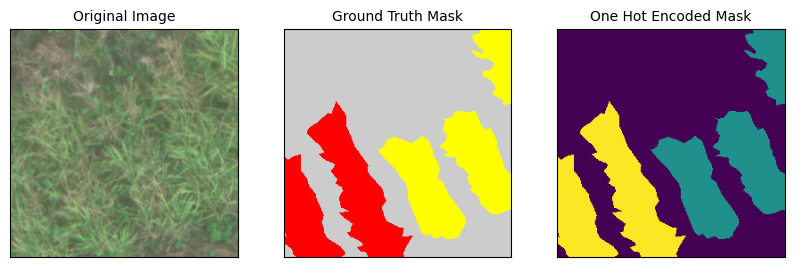

In [51]:
# test dataset for visualization (without preprocessing transformations)
test_dataset_vis = RiceDiseaseDataset(
    x_test_dir, y_test_dir,
    class_rgb_values=select_class_rgb_values,
    augmentation=None,  # No augmentation for test data
    preprocessing=None
)

# get a random test image/mask index
random_idx = random.randint(0, len(test_dataset_vis)-1)
image, mask = test_dataset_vis[random_idx]


print("Image shape:", image.shape)
print("Mask shape:", mask.shape)

visualize(
    original_image = image,
    ground_truth_mask = colour_code_segmentation(reverse_one_hot(mask), select_class_rgb_values),
    one_hot_encoded_mask = reverse_one_hot(mask)
)

In [ ]:
# #Describe the output shape of each prediction step

# random_idx = random.randint(0, len(test_dataset)-1)
# image, mask = test_dataset[random_idx]
# image_vis = test_dataset_vis[random_idx][0]

# print("Image shape:", image.shape)

# print("Image_vis shape:", image_vis.shape)

# x_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0)
# print("X_tensor shape", x_tensor.shape)

# pred_mask = best_model(x_tensor)
# print("pred_mask shape", pred_mask.shape) # Image > segmented image

# pred_mask = pred_mask.detach().squeeze().cpu().numpy()
# print("pred_mask shape detach", pred_mask.shape)

# # Convert pred_mask from `CHW` format to `HWC` format
# pred_mask = np.transpose(pred_mask,(1,2,0))
# print("pred_mask transpose shape", pred_mask.shape)

# pred_mask = colour_code_segmentation(reverse_one_hot(pred_mask), select_class_rgb_values)
# print("pred_mask apply colour code", pred_mask.shape)

# print("Mask shape before tranpose:", mask.shape)
# mask = np.transpose(mask,(1,2,0))
# print("Mask shape after tranpose:", mask.shape)
# mask = colour_code_segmentation(reverse_one_hot(mask), select_class_rgb_values)
# print("Mask shape apply colour code:", mask.shape)



# # Print unique values of pred_mask and mask after colour coding
# #unique_pred_mask_values = np.unique(pred_mask.reshape(-1, 3), axis=0)
# #unique_mask_values = np.unique(mask.reshape(-1, 3), axis=0)

# #print("Unique values in pred_mask:", unique_pred_mask_values)
# #print("Unique values in mask:", unique_mask_values)

# visualize(
#     original_image= image_vis,
#     ground_truth_mask= mask,
#     predicted_mask= pred_mask
# )

##Shape of results##

# #Image shape: (6, 256, 256)
# #Image_vis shape: (256, 256, 6)
# #X_tensor shape torch.Size([1, 6, 256, 256])
# #pred_mask shape torch.Size([1, 5, 256, 256])
# #pred_mask shape detach (5, 256, 256)
# #pred_mask transpose shape (256, 256, 5)
# #pred_mask apply colour code (256, 256, 3)
# #Mask shape before tranpose: (5, 256, 256)
# #Mask shape after tranpose: (256, 256, 5)
# #Mask shape apply colour code: (256, 256, 3)

In [ ]:
#1 Predicted mask (.tiff) (sample_preds_forder)


# Define your RGB to raster value mapping based on the table provided
rgb_to_raster = {
    (0, 0, 0): 0,
    (255, 255, 255): 1,
    (255, 255, 0): 2,
    (255, 165, 0): 3,
    (255, 0, 0): 4,
}

def convert_rgb_to_raster(image_rgb, mapping):
    """Convert a colour-coded segmentation mask to a single-channel raster image."""
    # Initialize an empty array for the single-channel raster
    raster = np.zeros((image_rgb.shape[0], image_rgb.shape[1]), dtype=np.uint8)

    # Iterate over the image and map the RGB to raster values
    for i in range(image_rgb.shape[0]):
        for j in range(image_rgb.shape[1]):
            rgb = tuple(image_rgb[i, j, :])
            raster[i, j] = mapping.get(rgb, 0)

    return raster

for idx in range(len(test_dataset)):
    image, _ = test_dataset[idx]
    original_image_path = test_dataset.get_image_path(idx)

    # Ensure the image file exists
    if not os.path.isfile(original_image_path):
        print(f"Image file does not exist: {original_image_path}")
        continue

    original_image_ds = gdal.Open(original_image_path)
    if original_image_ds is None:
        print(f"Failed to open image file with GDAL: {original_image_path}")
        continue

    geotransform = original_image_ds.GetGeoTransform()
    projection = original_image_ds.GetProjection()

    x_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0)

    pred_mask = model(x_tensor)
    pred_mask = pred_mask.detach().squeeze().cpu().numpy()
    if pred_mask.ndim == 3:
        pred_mask = np.transpose(pred_mask, (1, 2, 0))

    pred_mask = colour_code_segmentation(reverse_one_hot(pred_mask), select_class_rgb_values)
    pred_class_map = convert_rgb_to_raster(pred_mask, rgb_to_raster)

    output_file = os.path.join(sample_preds_folder, f"sample_pred_{idx}.tiff")

    driver = gdal.GetDriverByName('GTiff')
    dataset = driver.Create(output_file, pred_class_map.shape[1], pred_class_map.shape[0], 1, gdal.GDT_Byte)
    if dataset is None:
        print(f"Failed to create output file: {output_file}")
        continue

    dataset.SetGeoTransform(geotransform)
    dataset.SetProjection(projection)
    dataset.GetRasterBand(1).WriteArray(pred_class_map)
    dataset.FlushCache()
    dataset = None

    #print(f"Saved: {output_file}")

In [ ]:
# 2 Original image vs Predicted mask (.png) (sample_preds_folder2) (cv2 Colour code remaining)

for idx in range(len(test_dataset)):

    image, mask = test_dataset[idx]
    image_vis = test_dataset_vis[idx][0]  # This has multiple bands.

    # Prepare the tensor for the model.
    x_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0)

    # Get prediction from the model.
    pred_mask = model(x_tensor)
    pred_mask = pred_mask.detach().squeeze().cpu().numpy()
    # Convert pred_mask from `CHW` format to `HWC` format for processing.
    pred_mask = np.transpose(pred_mask, (1, 2, 0))
    pred_mask = colour_code_segmentation(reverse_one_hot(pred_mask), select_class_rgb_values)

    # Process the ground truth mask similarly.
    mask = np.transpose(mask, (1, 2, 0))
    mask = colour_code_segmentation(reverse_one_hot(mask), select_class_rgb_values)

    # Check the data type and range, normalize and convert if necessary.
    if image_vis.dtype != np.uint8:
        # Normalize to 0-255 and convert to uint8 if not already.
        image_vis_norm = (image_vis - image_vis.min()) / (image_vis.max() - image_vis.min()) * 255
        rgb_image_vis = np.uint8(image_vis_norm[:, :, [2, 1, 0]])  # Selecting and reordering RGB bands
    else:
        rgb_image_vis = image_vis[:, :, [2, 1, 0]]  # Just reordering if already uint8

    # Concatenate the images for saving. RGB order is now correct for OpenCV.
    combined_image = np.hstack([rgb_image_vis, pred_mask])

    # Save the combined image. No channel reversal needed, as OpenCV expects BGR.
    cv2.imwrite(os.path.join(sample_preds_folder2, f"sample_pred_{idx}.png"), combined_image)

In [ ]:
# 3 Original image / Ground truth mask / Predicted mask (.png) (sample_preds_folder3)

for idx in range(len(test_dataset)):

    image, mask = test_dataset[idx]
    image_vis = test_dataset_vis[idx][0]  # This has multiple bands.

    # Prepare the tensor for the model.
    x_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0)

    # Get prediction from the model.
    pred_mask = model(x_tensor)
    pred_mask = pred_mask.detach().squeeze().cpu().numpy()
    # Convert pred_mask from `CHW` format to `HWC` format for processing.
    pred_mask = np.transpose(pred_mask, (1, 2, 0))
    pred_mask = colour_code_segmentation(reverse_one_hot(pred_mask), select_class_rgb_values)

    # Process the ground truth mask similarly.
    mask = np.transpose(mask, (1, 2, 0))
    mask = colour_code_segmentation(reverse_one_hot(mask), select_class_rgb_values)

    # Check the data type and range, normalize and convert if necessary.
    if image_vis.dtype != np.uint8:
        # Normalize to 0-255 and convert to uint8 if not already.
        image_vis_norm = (image_vis - image_vis.min()) / (image_vis.max() - image_vis.min()) * 255
        rgb_image_vis = np.uint8(image_vis_norm[:, :, [2, 1, 0]])  # Selecting and reordering RGB bands
    else:
        rgb_image_vis = image_vis[:, :, [2, 1, 0]]  # Just reordering if already uint8

    # Concatenate the images for saving. RGB order is now correct for OpenCV.
    combined_image = np.hstack([rgb_image_vis, mask, pred_mask])

    # Save the combined image. No channel reversal needed, as OpenCV expects BGR.
    cv2.imwrite(os.path.join(sample_preds_folder3, f"sample_pred_{idx}.png"), combined_image)

    # Visualize (assuming this function displays but does not return an image).
    visualize(
        original_image=rgb_image_vis,
        ground_truth_mask=mask,
        predicted_mask=pred_mask
    )
